# Lab 5 - General Linear Models: Logistic regression

In [1]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

#### Read data from csv file

In [2]:
data = pd.read_csv("logistic_reg_data.csv")
data.describe()

,Unnamed: 0,x1,x2,x3,x4,x5,y
count,500.000000,500.000000,500.000000,500.000000,5.000000e+02,5.000000e+02,500.000000
mean,249.500000,-0.015777,0.334002,-0.001484,2.022817e-01,2.770684e-03,0.494000
std,144.481833,0.578292,0.301507,0.383111,2.738984e-01,3.107472e-01,0.500465
min,0.000000,-0.997592,0.000005,-0.992794,2.276756e-11,-9.880191e-01,0.000000
25%,124.750000,-0.515144,0.064052,-0.136718,4.102616e-03,-3.628888e-02,0.000000
50%,249.500000,-0.026042,0.254724,-0.000018,6.488454e-02,-1.278838e-08,0.000000
75%,374.250000,0.475396,0.555544,0.107440,3.086316e-01,2.428165e-02,1.000000
max,499.000000,0.999652,0.999305,0.998957,9.986100e-01,9.982628e-01,1.000000


### Prior selection


In [4]:
model_ppc1 = CmdStanModel(stan_file='logistic_regression_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [8]:
def sample_priors(sigma=10):
    R = 1000
    data_ppc = dict(N = data.shape[0],
                     M = 5,
                     X = data.iloc[:,0:5].values,
                     sigma=sigma)
    return model_ppc1.sample(data=data_ppc,
                               iter_sampling=R, iter_warmup=0,
                               chains=1,
                               refresh=R,
                               fixed_param=True,
                               seed=29042020)

In [9]:
sample_ppc1 = sample_priors()

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


#### Task 1.

1. Plot histograms of beta for prior model
2. Plot again the same histograms but this time with other sigma values. For instace use values: 5, 2, 0.75.
3. Consider which result should be taken into account when selecting prior.

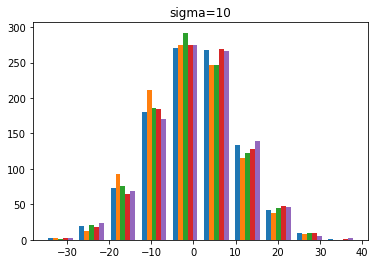

In [11]:
plt.hist(sample_ppc1.stan_variable("beta"))
plt.title("sigma=10")
plt.show()

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


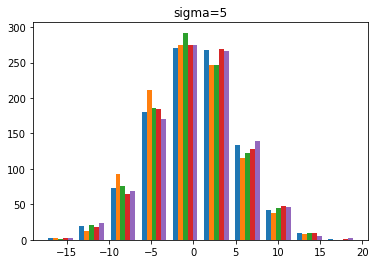

In [12]:
plt.hist(sample_priors(5).stan_variable("beta"))
plt.title("sigma=5")
plt.show()

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


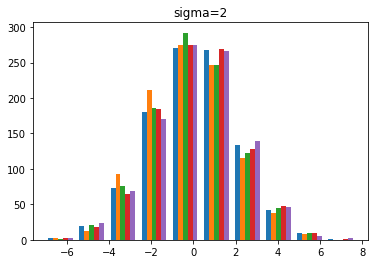

In [13]:
plt.hist(sample_priors(2).stan_variable("beta"))
plt.title("sigma=2")
plt.show()

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


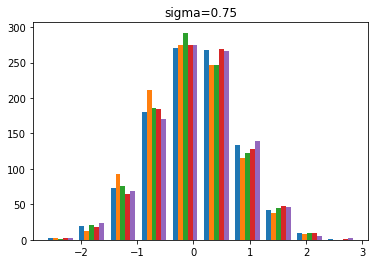

In [14]:
plt.hist(sample_priors(0.75).stan_variable("beta"))
plt.title("sigma=0.75")
plt.show()

### Posterior inference

In [15]:
model = CmdStanModel(stan_file='logistic_regression.stan')

INFO:cmdstanpy:compiling stan file /home/mat_komp/PycharmProjects/DataAnalytics/Lab5/logistic_regression.stan to exe file /home/mat_komp/PycharmProjects/DataAnalytics/Lab5/logistic_regression
INFO:cmdstanpy:compiled model executable: /home/mat_komp/PycharmProjects/DataAnalytics/Lab5/logistic_regression
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/mat_komp/PycharmProjects/DataAnalytics/Lab5/logistic_regression.hpp /home/mat_komp/PycharmProjects/DataAnalytics/Lab5/logistic_regression.stan
Warning in '/home/mat_komp/PycharmProjects/DataAnalytics/Lab5/logistic_regression.stan', line 5, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/mat_komp/PycharmProjects/DataAnalytics/Lab5/logistic_regression.stan', line 24, column 3: Declaration
    of arrays b

In [16]:
data_dict = dict(N = data.shape[0],
                 M = 5,
                 X = data.iloc[:,0:5].values,
                 y = data.y.values
                 )
fit = model.sample(data=data_dict, seed=4938483)

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing


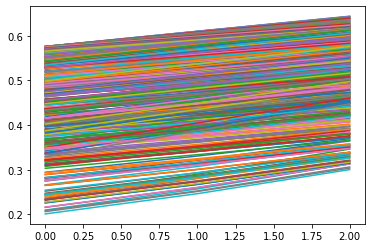

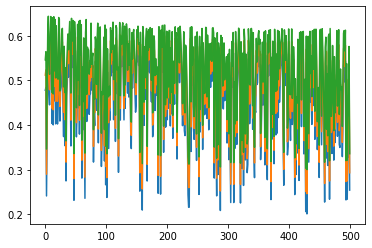

In [17]:
#plot
percentiles = np.percentile(fit.stan_variable('prob_ppc'), [25, 50, 75], axis=0)
plt.plot(percentiles)
plt.show()
percentiles_df = pd.DataFrame(percentiles.T, columns = ['lo', 'med', 'hi'])
plt.plot(percentiles_df)
plt.show()

#### Task 2.

1. Edit stan model and create models with different priors. Use original setting and some priors from task 1.
2. Fit the model
3. Plot the probability of individual outcome:
- plot generated paramether theta (prob_pcc): mean with its error bars (plt.errorbar)
- to plot its error bars take into consider its 25th, 50th and 75th percentile
- also mark the real value of y, by different colored dots (for mean values)
    
4. Consider if the probability was well captured by each setting

In [20]:
def all_the_stuff(sigma=10):
    data_dict_ = dict(N = data.shape[0],
                     M = 5,
                     X = data.iloc[:,0:5].values,
                     y = data.y.values,
                     sigma = sigma
                     )
    fit_ = model.sample(data=data_dict_, seed=4938483)
    means = []
    minimums = []
    maximums = []
    for row in fit_.stan_variable("prob_ppc").T:
        means.append(row.mean())
        minimums.append(row.min())
        maximums.append(row.max())

    plt.errorbar(range(len(means)), means, yerr=[minimums, maximums])
    plt.scatter(range(len(data.y)),data.y, color="red")
    plt.title("Full data for {} sigma".format(sigma))
    plt.show()

    num = 40
    plt.errorbar(range(num), means[:num], yerr=[minimums[:num], maximums[:num]])
    plt.scatter(range(num),data.y[:num], color="red")
    plt.title("First 40 values'")
    plt.show()

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing


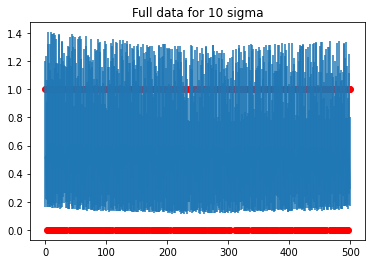

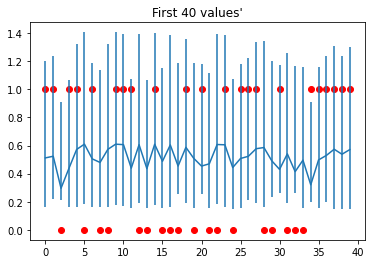

In [21]:
all_the_stuff()

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing


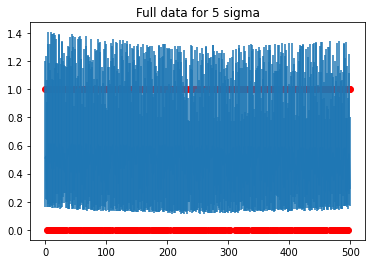

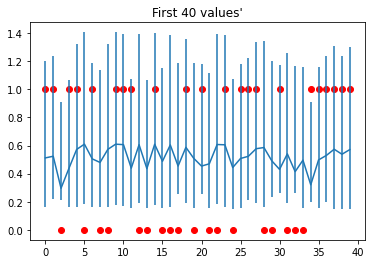

In [22]:
all_the_stuff(5)

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing


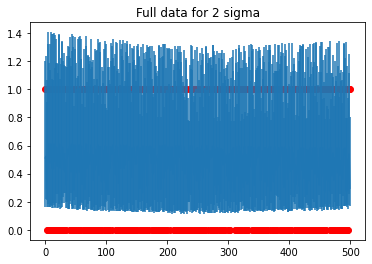

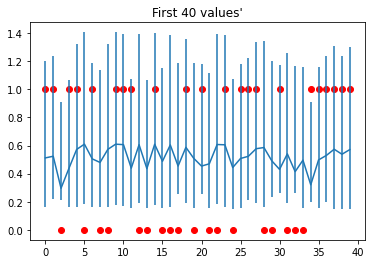

In [23]:
all_the_stuff(2)

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing


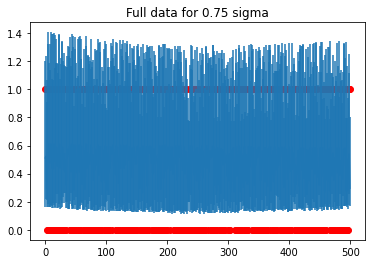

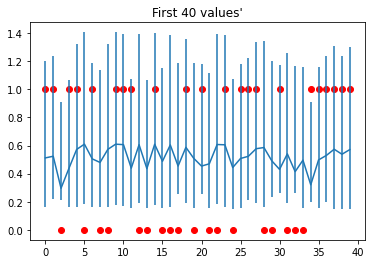

In [24]:
all_the_stuff(0.75)